# Isotope swapping

https://iopscience.iop.org/article/10.1088/0031-8949/T167/1/014062/pdf

Solving H transport problem:   0%|          | 0.00/1.00k [00:00<?, ?it/s]

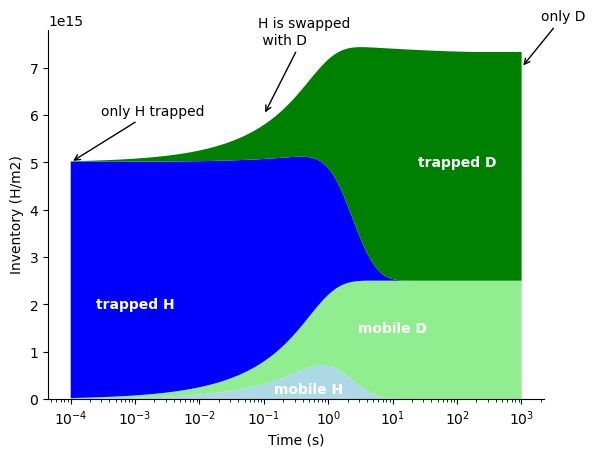

In [1]:
import matplotlib.pyplot as plt

import festim as F
import numpy as np

my_model = F.HydrogenTransportProblem()

# -------- Mesh --------- #

L = 5e-6
vertices = np.linspace(0, L, num=2000)
my_model.mesh = F.Mesh1D(vertices)


# -------- Materials and subdomains --------- #

w_atom_density = 6.3e28  # atom/m3

tungsten = F.Material(D_0=4.1e-7, E_D=0.39, name="tungsten")

my_subdomain = F.VolumeSubdomain1D(id=1, borders=[0, L], material=tungsten)
left_surface = F.SurfaceSubdomain1D(id=1, x=0)
right_surface = F.SurfaceSubdomain1D(id=2, x=L)

my_model.subdomains = [
    my_subdomain,
    left_surface,
    right_surface,
]

# -------- Hydrogen species and reactions --------- #

mobile_H = F.Species("H")
mobile_D = F.Species("D")


trapped_H = F.Species("trapped_H", mobile=False)
trapped_D = F.Species("trapped_D", mobile=False)

empty_trap = F.ImplicitSpecies(
    n=1e21,
    others=[trapped_H, trapped_D],
    name="empty_trap",
)


my_model.species = [
    mobile_H,
    mobile_D,
    trapped_H,
    trapped_D,
]
k_0 = 4.1e-7 / (1.1e-10**2 * 6 * w_atom_density)
my_model.reactions = [
    F.Reaction(
        k_0=k_0,
        E_k=0.39,
        p_0=1e13,
        E_p=1.2,
        reactant1=mobile_H,
        reactant2=empty_trap,
        product=trapped_H,
        volume=my_subdomain,
    ),
    F.Reaction(
        k_0=k_0,
        E_k=0.39,
        p_0=1e13,
        E_p=1.2,
        reactant1=mobile_D,
        reactant2=empty_trap,
        product=trapped_D,
        volume=my_subdomain,
    ),
    F.Reaction(
        k_0=k_0,
        E_k=0.1,
        p_0=k_0,
        E_p=0.1,
        reactant1=mobile_H,
        reactant2=trapped_D,
        product=[mobile_D, trapped_H],
        volume=my_subdomain,
    ),
]

# -------- Temperature --------- #

my_model.temperature = 400

# -------- Boundary conditions --------- #


my_model.boundary_conditions = [
    F.DirichletBC(subdomain=left_surface, value=0, species=mobile_H),
    F.DirichletBC(subdomain=right_surface, value=0, species=mobile_H),
    F.DirichletBC(subdomain=left_surface, value=1e21, species=mobile_D),
    F.DirichletBC(subdomain=right_surface, value=0, species=mobile_D),
]

# -------- Initial conditions --------- #

my_model.initial_conditions = [
    F.InitialCondition(value=1e21, species=trapped_H),
    # F.InitialCondition(value=1e21, species=mobile_D),
]

# -------- Exports --------- #

left_flux = F.SurfaceFlux(field=mobile_H, surface=left_surface)
right_flux = F.SurfaceFlux(field=mobile_H, surface=right_surface)
total_H_mobile = F.TotalVolume(mobile_H, my_subdomain)
total_D_mobile = F.TotalVolume(mobile_D, my_subdomain)
total_H_trapped = F.TotalVolume(trapped_H, my_subdomain)
total_D_trapped = F.TotalVolume(trapped_D, my_subdomain)

folder = "swapping_term_example"

my_model.exports = [
    F.XDMFExport(f"{folder}/mobile_concentration_h.xdmf", field=mobile_H),
    F.XDMFExport(f"{folder}/mobile_concentration_d.xdmf", field=mobile_D),
    F.XDMFExport(f"{folder}/trapped_concentration_h1.xdmf", field=trapped_H),
    F.XDMFExport(f"{folder}/trapped_concentration_d1.xdmf", field=trapped_D),
    left_flux,
    right_flux,
    total_H_mobile,
    total_D_mobile,
    total_H_trapped,
    total_D_trapped,
]

# -------- Settings --------- #

my_model.settings = F.Settings(
    atol=1e10, rtol=1e-10, max_iterations=30, final_time=1000
)

my_model.settings.stepsize = F.Stepsize(
    initial_value=1e-4, growth_factor=1.1, target_nb_iterations=4
)

# -------- Run --------- #
# import dolfinx

# dolfinx.log.set_log_level(dolfinx.log.LogLevel.INFO)

my_model.initialise()

# print(my_model.formulation)

# exit()
my_model.run()


# -------- Plot --------- #


times = total_H_mobile.t
data_mobile_H = total_H_mobile.data
data_mobile_D = total_D_mobile.data
data_trapped_H = total_H_trapped.data
data_trapped_D = total_D_trapped.data

# colours are blue and light blue for H (mobile trapped)
# green and light green for D (mobile trapped)

plt.stackplot(
    times,
    data_mobile_H,
    data_mobile_D,
    data_trapped_H,
    data_trapped_D,
    labels=["mobile_H", "mobile_D", "trapped_H", "trapped_D"],
    colors=["lightblue", "lightgreen", "blue", "green"],
)

plt.annotate(
    "mobile H", (0.5, 0.2e15), color="white", va="center", ha="center", weight="bold"
)
plt.annotate(
    "mobile D", (10, 1.5e15), color="white", va="center", ha="center", weight="bold"
)
plt.annotate(
    "trapped H", (1e-3, 2e15), color="white", va="center", ha="center", weight="bold"
)
plt.annotate(
    "trapped D", (1e2, 5e15), color="white", va="center", ha="center", weight="bold"
)
# plt.legend(reverse=True)

plt.annotate(
    "only H trapped",
    (1e-4, 5e15),
    xytext=(3e-4, 6e15),
    arrowprops=dict(arrowstyle="->"),
)

plt.annotate(
    "H is swapped \n with D",
    (1e-1, 6e15),
    xytext=(8e-2, 7.5e15),
    arrowprops=dict(arrowstyle="->"),
)

plt.annotate(
    "only D",
    (1e3, 7e15),
    xytext=(2e3, 8e15),
    arrowprops=dict(arrowstyle="->"),
)

plt.xscale("log")
plt.xlabel("Time (s)")
plt.ylabel("Inventory (H/m2)")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.savefig("swapping_term_example/inventory.png", dpi=300, bbox_inches="tight")
plt.savefig("swapping_term_example/inventory.svg", bbox_inches="tight")
plt.show()